In [1]:
!pip install pymatreader

import pandas
import numpy
import os
from pymatreader import read_mat

Defaulting to user installation because normal site-packages is not writeable


In [2]:
def listFiles(dir_):
    cwd = os.getcwd()
    dir_ = os.path.join(cwd, dir_)
    file_list = list()
    walk = os.walk(dir_)
    for root, dirs, files in walk:
        for file in files:
            file_name = os.path.join(root, file)
            file_list.append(file_name)
    return file_list

In [4]:
from shapely.geometry import Polygon

def tumorSize(tumorVector):
    x = tumorVector[::2]
    y = tumorVector[1::2]
    return Polygon(zip(x,y)).area

In [5]:
def tumorRatio(tumorMask, shape):
    tumor_pixels = numpy.count_nonzero(tumorMask)
    return tumor_pixels/shape

In [8]:
file_list = listFiles('./Data')

In [7]:
from matplotlib import image
count = 0

def imageInfo(image_):
    global count
    image_info = dict()
    
    image_shape = image_['image'].shape[0] * image_['image'].shape[1]
    image_info['PID'], image_info['label'] = image_['PID'], image_['label']
    image_info['tumorSize'] = tumorSize(image_['tumorBorder'])
    image_info['tumorRatio'] = tumorRatio(image_['tumorMask'], image_shape)
    fileLocation =  './Image/'+image_['PID']+'_'+str(count)+'.jpg'
    maskLocation = './Mask/'+image_['PID']+'_'+str(count)+'.jpg'
    image.imsave(fileLocation, image_['image'], cmap='gray')
    image.imsave(maskLocation, image_['tumorMask'], cmap='gray')
    image_info['fileLocation'] = fileLocation
    image_info['maskLocation'] = maskLocation
    image_info['shape'] = str(image_['image'].shape)
    count += 1
    return image_info

In [9]:
info_data = pandas.DataFrame(columns=['PID', 'label', 'tumorSize', 'tumorRatio', 'fileLocation', 'maskLocation', 'shape'])

In [10]:
def imageToDataFrame(image_):
    info_data.loc[len(info_data), info_data.columns] = list(imageInfo(image_).values())    
    del(image_)

In [11]:
def allImagesToDataFrames(files):
    for file in files:
        data = read_mat(file)['cjdata']
        imageToDataFrame(data)
        del(data)

In [12]:
allImagesToDataFrames(file_list)
info_data.reset_index(drop=True).to_csv('info_data.csv', index=False)

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings

In [15]:
df=pandas.read_csv("./info_data.csv")

In [17]:
df.head()

,PID,label,tumorSize,tumorRatio,fileLocation,maskLocation,shape
0,103673,1.0,1434.631129,0.005508,./Image/103673_0.jpg,./Mask/103673_0.jpg,"(512, 512)"
1,MR051644C,2.0,8424.624856,0.032154,./Image/MR051644C_1.jpg,./Mask/MR051644C_1.jpg,"(512, 512)"
2,97890,3.0,1068.145540,0.004063,./Image/97890_2.jpg,./Mask/97890_2.jpg,"(512, 512)"
3,98652,3.0,798.821693,0.003017,./Image/98652_3.jpg,./Mask/98652_3.jpg,"(512, 512)"
4,108931,3.0,488.475657,0.007507,./Image/108931_4.jpg,./Mask/108931_4.jpg,"(256, 256)"


In [18]:
df.shape

(3064, 7)

In [19]:
df.dtypes.sort_values(ascending=True)

label           float64
tumorSize       float64
tumorRatio      float64
PID              object
fileLocation     object
maskLocation     object
shape            object
dtype: object

In [20]:
display(df.isnull().sum())
print("")
print(f"Are there any missing values? {df.isnull().values.any()}") 

PID             0
label           0
tumorSize       0
tumorRatio      0
fileLocation    0
maskLocation    0
shape           0
dtype: int64


Are there any missing values? False


In [21]:
df.rename(columns={"label":"Type of Tumour",
                   "PID":"Patient ID",}
          ,inplace=True)
df.head()

,Patient ID,Type of Tumour,tumorSize,tumorRatio,fileLocation,maskLocation,shape
0,103673,1.0,1434.631129,0.005508,./Image/103673_0.jpg,./Mask/103673_0.jpg,"(512, 512)"
1,MR051644C,2.0,8424.624856,0.032154,./Image/MR051644C_1.jpg,./Mask/MR051644C_1.jpg,"(512, 512)"
2,97890,3.0,1068.145540,0.004063,./Image/97890_2.jpg,./Mask/97890_2.jpg,"(512, 512)"
3,98652,3.0,798.821693,0.003017,./Image/98652_3.jpg,./Mask/98652_3.jpg,"(512, 512)"
4,108931,3.0,488.475657,0.007507,./Image/108931_4.jpg,./Mask/108931_4.jpg,"(256, 256)"


In [22]:
cols = df.columns
print("Features in Datasets: ")
print(cols)
print("\nNo of Features in Dataset: ", len(cols))

Features in Datasets: 
Index(['Patient ID', 'Type of Tumour', 'tumorSize', 'tumorRatio',
       'fileLocation', 'maskLocation', 'shape'],
      dtype='object')

No of Features in Dataset:  7


In [23]:
numerical_cols = list(df.select_dtypes(exclude = ['object']))
print("Numerical Columns are : ", numerical_cols)

Numerical Columns are :  ['Type of Tumour', 'tumorSize', 'tumorRatio']


In [24]:
categorical_cols = list(df.select_dtypes(include = ['object']))
print("Categorical Columns are : ", categorical_cols)

Categorical Columns are :  ['Patient ID', 'fileLocation', 'maskLocation', 'shape']


In [25]:
numerical_cols = list(df.select_dtypes(exclude = ['object']))
describe=df[numerical_cols].describe()
describe = describe.append(pandas.Series(df[numerical_cols].nunique(), name='Unique Values'))
describe = describe.append(pandas.Series(df[numerical_cols].isnull().sum(), name='Missing Values'))
describe = describe.append(pandas.Series(df[numerical_cols].var(), name='Variance'))
describe = describe.append(pandas.Series(df[numerical_cols].skew(), name='Skewness'))
describe = describe.append(pandas.Series(df[numerical_cols].kurtosis(), name='Kurtosis'))
describe.T

/tmp/ipykernel_74843/2192738034.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  describe = describe.append(pandas.Series(df[numerical_cols].nunique(), name='Unique Values'))
/tmp/ipykernel_74843/2192738034.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  describe = describe.append(pandas.Series(df[numerical_cols].isnull().sum(), name='Missing Values'))
/tmp/ipykernel_74843/2192738034.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  describe = describe.append(pandas.Series(df[numerical_cols].var(), name='Variance'))
/tmp/ipykernel_74843/2192738034.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  describe = describe.append(pa

,count,mean,std,min,25%,50%,75%,max,Unique Values,Missing Values,Variance,Skewness,Kurtosis
Type of Tumour,3064.0,2.072454,0.727680,1.000000,2.000000,2.000000,3.000000,3.000000,3.0,0.0,5.295185e-01,-0.111669,-1.107130
tumorSize,3064.0,4421.620729,3618.212034,161.017470,1707.102512,3369.048860,6060.254330,25464.430550,3061.0,0.0,1.309146e+07,1.459133,2.289978
tumorRatio,3064.0,0.016901,0.013790,0.000973,0.006537,0.012856,0.023205,0.097126,2594.0,0.0,1.901560e-04,1.460060,2.292306


In [26]:
df['Tumour_bins'] = pandas.cut(df['Type of Tumour'], bins = [0,1,2,3], 
                              labels=['Meningioma', 'Glioma', 'Pituitary'])
df_Tumour_bins = pandas.DataFrame(df['Tumour_bins'].value_counts()).reset_index()
df_Tumour_bins.rename(columns = {'index':'Tumour_bins', 'Tumour_bins':'count'}, inplace= True)

fig = px.pie(df_Tumour_bins, values = 'count', names = 'Tumour_bins', hole = 0.05,color_discrete_map='Tumour_bins', color_discrete_sequence=px.colors.qualitative.Bold)
fig.update_traces(textposition='inside', textinfo='percent+label',marker=dict(line=dict(color='#FFFFFF', width=2)))
fig.update_layout(title_text="Type of Tumour Distribution in Dataset",title_x=0.5)

fig.show()

In [27]:
fig = px.histogram(df, x="tumorSize",facet_col='Tumour_bins',color='Tumour_bins',
                   title="Tumour Size Distribution")
fig.show()

fig = px.histogram(df, x="tumorSize",color='Tumour_bins',
                   title="Tumour Size Distribution")


fig.show()

In [28]:
fig = px.histogram(df, x="tumorRatio",facet_col='Tumour_bins',color='Tumour_bins',
                   title="Tumour Ratio Distribution")
fig.show()

fig = px.histogram(df, x="tumorRatio",color='Tumour_bins',
                   title="Tumour Ratio Distribution")

fig.show()

In [29]:
fig = px.histogram(df,x="tumorSize",y="tumorRatio",color='Tumour_bins',
                   title="Tumour Size vs Ratio Distribution",color_discrete_sequence=px.colors.qualitative.Prism)


fig.show()

Text(0.5, 0.98, 'JointPlot showing Tumor Ratio v/s Tumor Size')

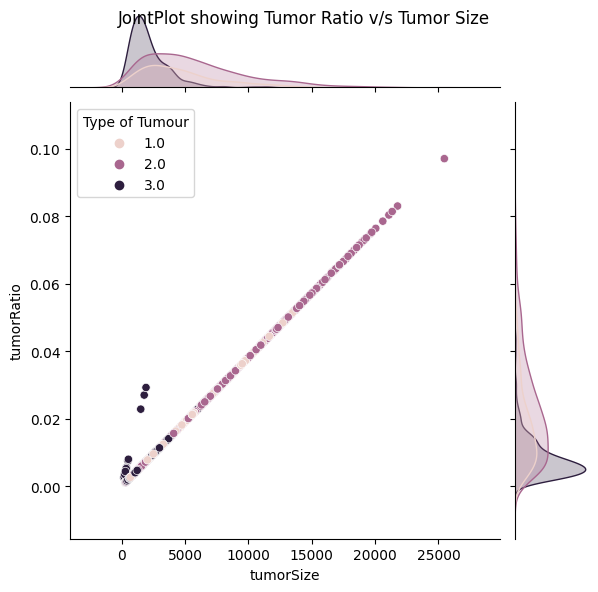

In [30]:
p=sns.jointplot(x="tumorSize",y="tumorRatio",data=df,hue="Type of Tumour")
p.fig.suptitle("JointPlot showing Tumor Ratio v/s Tumor Size")

In [31]:
fig = px.scatter(df, x="tumorSize", y="tumorRatio", color="Type of Tumour",
                 marginal_x="rug", marginal_y="histogram", title="Tumour Size vs Ratio Distribution")
fig.show()

/home/abiggj/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




Text(0.5, 0.98, 'Tumor Size Distribution Plot with Tumor Type')

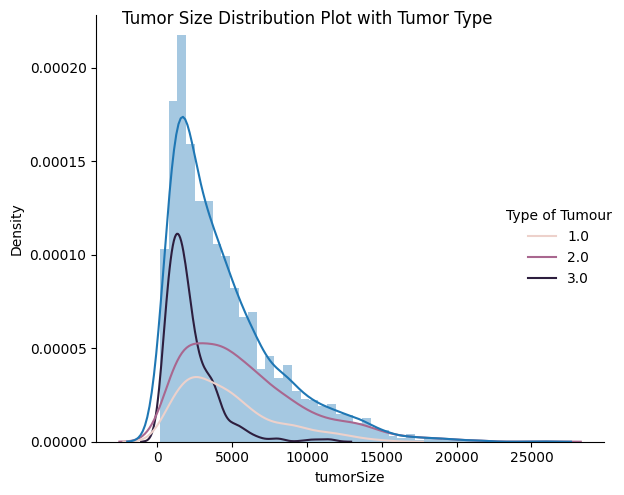

In [32]:
q=sns.displot(data=df,x='tumorSize',kind='kde',hue='Type of Tumour').map(sns.distplot, 'tumorSize').add_legend();
q.fig.suptitle("Tumor Size Distribution Plot with Tumor Type")

In [33]:
fig = px.scatter(
    df, x='tumorRatio', y='Type of Tumour', opacity=0.65,
    trendline='ols', trendline_color_override='darkblue',title="Tumour Type vs Ratio")
fig.show()

In [34]:
fig = px.violin(df, x="Type of Tumour", y="tumorSize",title="Tumour Size vs Tumour Type")
fig.show()

In [35]:
a= ['tumorSize', 'tumorRatio', 'Type of Tumour']
fig = px.imshow(round(df[a].corr(), 2),text_auto=True,  aspect="auto", color_continuous_scale='amp')
fig.update_layout(title_text="Correlation HeatMap",title_x=0.48)
fig.layout.height = 500
fig.layout.width = 500
fig.show()

In [36]:
fig = px.scatter_3d(df, x = 'Type of Tumour', y = 'tumorSize', z = 'tumorRatio',
                    color = 'Tumour_bins', size = 'tumorRatio',
                    symbol = 'Type of Tumour', hover_name='Tumour_bins',title="3D scatter plot")
fig.show()

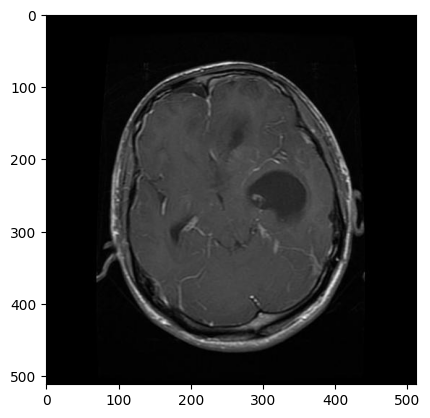

In [27]:
from matplotlib import image
image_addr = df.iloc[0]['fileLocation']
plt.imshow(image.imread(image_addr))

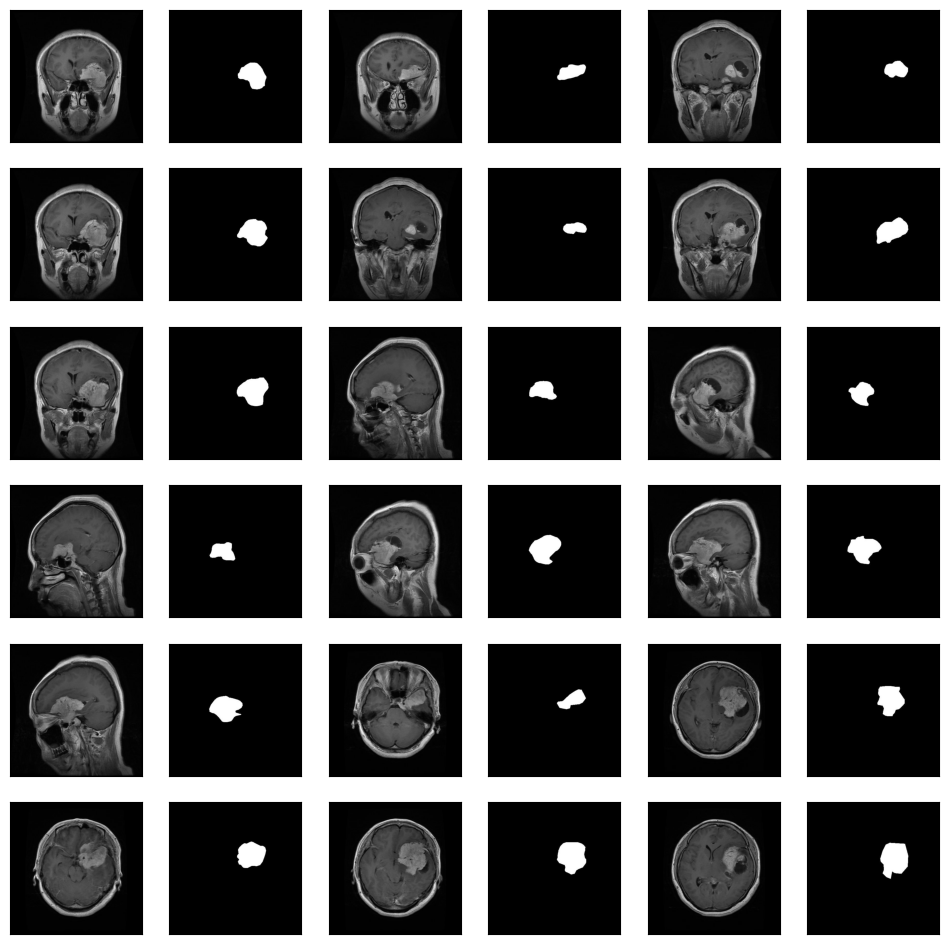

In [28]:
fig = plt.figure(figsize=(12, 12))
i = 1
axes = []
rows, columns = 6, 6
for name, group in df.groupby('Patient ID'):
    global i
    for fileName, maskName in zip(group['fileLocation'], group['maskLocation']):
        axes.append(fig.add_subplot(rows, columns, i))
        plt.imshow(image.imread(fileName))
        i += 1
        axes.append(fig.add_subplot(rows, columns, i))
        plt.imshow(image.imread(maskName))
        i += 1
    break
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])